In [4]:
'''Create a set of TFRecords files for training our model'''

import glob
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import argparse
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline


In [7]:
input_dir = 'data/retina_data_subset/'
output_dir = 'data/retina_data_subset_preprocessed/'
illnesses = ['altpig', 'dmae', 'excavation', 'membrana', 'nevus']

In [10]:
# Count the number of files in each directory and perform a summary in a table
count = 0
for illness in illnesses:
    illness_dir = 'u_{}_symbolic_512'.format(illness)    
    for mode in ['test', 'train', 'validation']:    
        for class_type in [illness, 'normal']:
            count += 1
            filenames_dir = os.path.join(input_dir, illness_dir, mode, class_type)
            filenames = [f for f in os.listdir(filenames_dir) if f.endswith('jpg')]
            
            if class_type == 'normal' and mode == 'train':
                print('Number of files in {}/{}/{}: {}'.format(illness, mode, class_type, len(filenames)))
print('Number of total directories: {}'.format(count))

Number of files in altpig/train/normal: 267
Number of files in dmae/train/normal: 1000
Number of files in excavation/train/normal: 382
Number of files in membrana/train/normal: 246
Number of files in nevus/train/normal: 279
Number of total directories: 30


## Data Preprocessing
Should we need to apply some preprocessing before turning our images into TFRecords, we can create the functions in this section (resize, applying filters...)

In [4]:
def resize_and_save(filename, output_dir, output_size):
    '''
    Given a filename from an image, resize it into (output_size, output_size) and save it into the ouput_dir path
    '''
    
    img = Image.open(filename)
    img = img.resize(size=(output_size, output_size), resample=Image.BILINEAR)
    img.save(output_dir)
    
    
def resize_images_from_dir(input_parent_dir, illnesses_list, output_parent_dir, output_image_size):
    '''
    Given a parent directory, get all the images from inside, resize them into (output_image_size, output_image_size)
    and save them into a output parent directory with the same structure
    '''
    
    for illness in illnesses_list:
        illness_dir = 'u_{}_symbolic_512'.format(illness)    
        for mode in ['test', 'train', 'validation']:    
            for class_type in [illness, 'normal']:
                filenames_dir = os.path.join(input_parent_dir, illness_dir, mode, class_type)
                filenames = [f for f in os.listdir(filenames_dir) if f.endswith('jpg')]

                print('Processing files located at {}'.format(filenames_dir))
                for i, file in enumerate(filenames):
                    if i % 500 == 0:
                        # Print some feedback information about the process
                        print('{}/{} files processed'.format(i, len(filenames)))
                    if i == (len(filenames) - 1):
                        print('{}/{} files processed'.format(i+1, len(filenames)))

                    # Join all the parts of the filenames
                    img_path = os.path.join(input_dir, illness_dir, mode, class_type, file)
                    output_dir_file = os.path.join(output_parent_dir, illness_dir, mode, class_type, file)
                    # Resize the image to the desired shape and save it at the output directory
                    resize_and_save(filename=img_path, output_dir=output_dir_file, output_size=output_image_size)

## Create the TFRecords file
We will have 3 different sets of files: Training, validation and testing. Each file will contain shuffled images of both all the illnesses and the 'normal' group with the corresponding label
Each file will contain 200 coded images tops (This number may change, and needs to be a not hardcoded parameter)

We will create a preproc_fn() in which we will code a possible preprocessing

6 different classes:
 - normal = 0
 - altpig = 1
 - dmae = 2
 - excavation = 3
 - membrana = 4
 - nevus = 5


In [5]:
def get_labels_from_illness(illness, n_filenames):
    '''
    Returns a list with the id of the illness and length of n_filenames
    '''
    
    assert illness in ['normal', 'altpig', 'dmae', 'excavation', 'membrana', 'nevus'], 'The introduced illness does not exist'
    assert n_filenames != 0, 'The number of filenames should be greater than 0'
    
    if illness == 'normal':
        illness_id = 0
    elif illness == 'altpig':
        illness_id = 1
    elif illness == 'dmae':
        illness_id = 2
    elif illness == 'excavation':
        illness_id = 3
    elif illness == 'membrana':
        illness_id = 4
    elif illness == 'nevus':
        illness_id = 5
    else:
        raise ValueError('The introduced illness "{}" does not exist.'.format(illness))
    
    return [illness_id]*n_filenames

def get_filenames_labels_mode(parent_dir, mode_to_retrieve, shuffle = False):
    '''
    Given the parent_dir and the mode ('train', 'test', 'validation'), this function returns a dictionary with the names of
    all the filenames found inside the parent directory and the corresponding labels
    '''
    
    assert os.path.isdir(parent_dir), 'The parent directory specified does not exist'
    assert mode_to_retrieve in ['train', 'test', 'validation'], 'The specified mode does not exist. Options: "train", "test", "validation"'

    illness_dirs = glob.glob(parent_dir + '/*') # illness level
    filenames = [] # create an empty list for saving the filenames
    labels = [] # create an empty list for saving the labels
    
    for illness_dir in illness_dirs:

        mode_dirs = glob.glob(illness_dir + '/*') # mode level
        
        for mode_dir in mode_dirs:
            mode = mode_dir.split('/')[-1] # retrieve the last part of the pathname (the mode)
            if mode == mode_to_retrieve:
                class_dirs = glob.glob(mode_dir + '/*') # class level
                
                for class_dir in class_dirs:
                    illness = class_dir.split('/')[-1] # get which illness are we processing now
                    
                    # Retrieve the filenames and corresponding labels
                    filenames_to_retrieve = [f for f in glob.glob(class_dir + '/*') if f.endswith('.jpg')]
                    labels_to_retrieve = get_labels_from_illness(illness=illness, n_filenames=len(filenames_to_retrieve))
                    
                    assert len(filenames_to_retrieve) == len(labels_to_retrieve), 'The lengths of the retrieve filenames and labels do not coincide.'
                    
                    # Append the previous results to the overall lists
                    filenames = filenames + filenames_to_retrieve
                    labels = labels + labels_to_retrieve

    # Check everything is going smooth
    assert len(filenames) == len(labels), 'The lengths of the total filenames and labels do not coincide.'
    
    # Shuffle the lists randomly if specified
    if shuffle:
        z = list(zip(filenames, labels))
        random.shuffle(z)
        filenames, labels = zip(*z)   
    
    out = {'filenames': filenames, 'labels':labels}
    
    return out

In [6]:
train_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/', mode_to_retrieve='train', shuffle=True)
n_train = len(train_inputs['filenames'])
print('Train size: {}'.format(n_train))

validation_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/', mode_to_retrieve='validation', shuffle=True)
n_val = len(validation_inputs['filenames'])
print('Validation size: {}'.format(n_val))

test_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/', mode_to_retrieve='test', shuffle=True)
n_test = len(test_inputs['filenames'])
print('Test size: {}'.format(n_test))

Train size: 3735
Validation size: 884
Test size: 1170


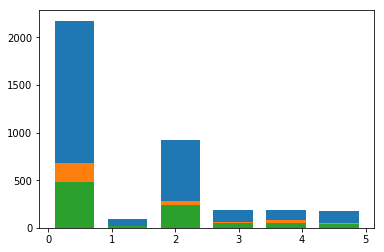

In [7]:
# Distribution of the classes
train_hist = plt.hist(x=train_inputs['labels'], bins = 6, histtype='bar', rwidth = 0.75)
test_hist = plt.hist(x=test_inputs['labels'], bins = 6, histtype='bar', rwidth = 0.75)
valiation_hist = plt.hist(x=validation_inputs['labels'], bins = 6, histtype='bar', rwidth = 0.75)

In [25]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_list_to_TFRecord(image_paths, labels, output_name, output_size_files = 200, resize = False, new_size = None):
    '''
    Args:
    image_paths           List of file-paths for the images.
    labels                Class-labels for the images.
    output_name           File-name for the TFRecords output file, without the extension (.tfrecords)   
    output_size_files     Number of images saved in each .tfrecords file
    resize                Boolean indicating whether we want the images resized before saving them into TFRecords
    new_size              Integer indicating the new size of the images. Deprecated if resize = False
    '''
    
    assert len(image_paths) == len(labels), 'Number of image paths and labels do not coincide.'
    
    # Compute the number of needed TFRecords files
    n_files_created = 0
    n_files_needed = len(image_paths)//output_size_files + 1
    n_written_images = 0
    
    # Iterate over the diferent TFRecords files that will be created
    for file_id in range(n_files_needed):
        output_file_name = output_name + '_' + str(file_id) + '.tfrecords'
        print("Creating new file: {}".format(output_file_name))
        n_files_created += 1
        
        # Retrieve the next batch of size 'output_size_files' of filenames and labels
        initial_image_id = file_id * output_size_files
        final_image_id = (file_id + 1) * output_size_files
        image_paths_to_be_coded = image_paths[initial_image_id:final_image_id]
        labels_to_be_coded = labels[initial_image_id:final_image_id]
        
        # Bug-free code
        assert len(image_paths_to_be_coded) == len(labels_to_be_coded), 'The next batch of filenames, labels has a mismatch of lenghts'
        
        # Open a new TFRecordWriter to write the filenames and labels into a TFRecords file
        with tf.python_io.TFRecordWriter(output_file_name) as writer:
        
            # Iterate over all the image-paths and class-labels.
            for i, (path, label) in enumerate(zip(image_paths_to_be_coded, labels_to_be_coded)):

                # Load the image-file using matplotlib's imread function.
                img = Image.open(path)
                # Resize the image to the desired size
                if resize:
                    img = img.resize(size=size, resample=Image.BILINEAR)
                # Transform the image into a numpy array and get the features to save
                img = np.asarray(img, dtype=np.float32)
                rows, cols, depth = img.shape[0], img.shape[1], img.shape[2]
                # Convert the image to raw bytes.
                img_bytes = tf.compat.as_bytes(img.tostring())
                # Create a dict with the data we want to save in the
                # TFRecords file. You can add more relevant data here.
                data = {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label),
                    'height': wrap_int64(rows),
                    'width': wrap_int64(cols),
                    'depth': wrap_int64(depth),
                }
                # Wrap the data as TensorFlow Features.
                feature = tf.train.Features(feature=data)
                # Wrap again as a TensorFlow Example.
                example = tf.train.Example(features=feature)
                # Serialize the data.
                serialized = example.SerializeToString()
                # Write the serialized data to the TFRecords file.
                writer.write(serialized)
                # Update the number of written images for printing the process
                n_written_images += 1
                
        # Print the progress at the end of every file and flush the memory
        print('Progress: {}/{} images converted'.format(n_written_images, len(labels)))
        # Check that the created file has the expected amount of files
        len_tfrecord = len([x for x in tf.python_io.tf_record_iterator(output_file_name)])
        assert len_tfrecord == len(image_paths_to_be_coded), 'Expected size of the TFRecord file does not coincide with the input size of the list of filenames'
        # Flush the memory
        sys.stdout.flush()

In [30]:
train_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/',
                                              mode_to_retrieve='train', shuffle=True)
validation_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/',
                                              mode_to_retrieve='validation', shuffle=True)
test_inputs = get_filenames_labels_mode(parent_dir='retina_data_subset/',
                                              mode_to_retrieve='test', shuffle=True)

print('----- Creating train files')
convert_list_to_TFRecord(
    image_paths=train_inputs['filenames'],
    labels=train_inputs['labels'],
    output_name = ('retina_TFRecords/train/train'),
    output_size_files = 200,
    resize = False
)

print('----- Creating validation files')
convert_list_to_TFRecord(
    image_paths=validation_inputs['filenames'],
    labels=validation_inputs['labels'],
    output_name = ('retina_TFRecords/validation/validation'),
    output_size_files = 200,
    resize = False
)

print('----- Creating test files')
convert_list_to_TFRecord(
    image_paths=test_inputs['filenames'],
    labels=test_inputs['labels'],
    output_name = ('retina_TFRecords/test/test'),
    output_size_files = 200,
    resize = False
)

print('TFRecord converter process finished.')

----- Creating train files
Creating new file: retina_TFRecords/train/train_0.tfrecords
Progress: 200/3735 images converted
Creating new file: retina_TFRecords/train/train_1.tfrecords
Progress: 400/3735 images converted
Creating new file: retina_TFRecords/train/train_2.tfrecords
Progress: 600/3735 images converted
Creating new file: retina_TFRecords/train/train_3.tfrecords
Progress: 800/3735 images converted
Creating new file: retina_TFRecords/train/train_4.tfrecords
Progress: 1000/3735 images converted
Creating new file: retina_TFRecords/train/train_5.tfrecords
Progress: 1200/3735 images converted
Creating new file: retina_TFRecords/train/train_6.tfrecords
Progress: 1400/3735 images converted
Creating new file: retina_TFRecords/train/train_7.tfrecords
Progress: 1600/3735 images converted
Creating new file: retina_TFRecords/train/train_8.tfrecords
Progress: 1800/3735 images converted
Creating new file: retina_TFRecords/train/train_9.tfrecords
Progress: 2000/3735 images converted
Creatin